torch.Size([32, 3, 256, 256])


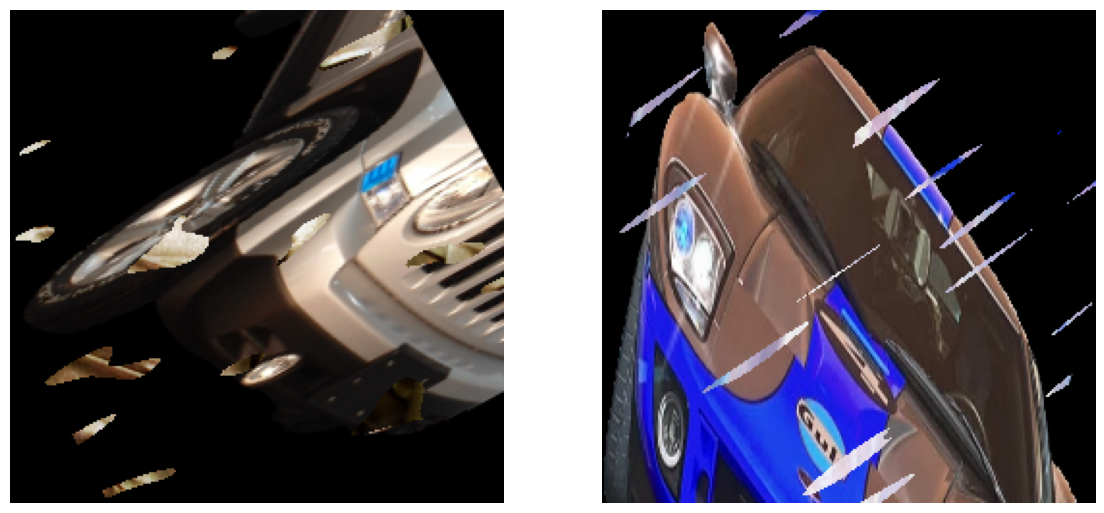

In [1]:

from data_loader import MVTecDRAEMTrainDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

def train_on_device(obj_names, args):


    for obj_name in obj_names:



        dataset = MVTecDRAEMTrainDataset(args.data_path + obj_name + "/train/good/", args.anomaly_source_path, resize_shape=[256, 256], ignore_black_region=False)

        dataloader = DataLoader(dataset, batch_size=args.bs,
                                shuffle=True, num_workers=1)
        

                # Get a batch of data
        batch_idx, batch_data = next(enumerate(dataloader))

        # Extract images from the batch
        images = batch_data['augmented_image']
        batch_idx, batch_data = next(enumerate(dataloader))

        # Extract images from the batch
        images = batch_data['augmented_image']
        print(images.shape)
        has_anomaly = batch_data['has_anomaly']

        imgs = []
        q=0
        for anom in has_anomaly:
             if anom:
                  imgs.append(images[q])
             q+=1
     
        # Plot the imagee
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Create a 1x2 grid of subplots

        # Loop through the first 2 images
        for i in range(2):
            if i < len(imgs):  # Ensure i is within bounds of imgs
                axes[i].imshow(np.transpose(imgs[i], (1, 2, 0)))  # Assuming images are in (channels, height, width) format
                axes[i].axis('off')  # Turn off axis

        plt.savefig('anomaly_aug_example_focus.png')  # Save the figure
        plt.show()  # Display the plot
        '''
        fig, axes = plt.subplots(2, 2, figsize=(28, 28))


        for i in range(2):
            for j in range(2):
                idx = i * 2 + j
                axes[i, j].imshow(np.transpose(imgs[idx], (1, 2, 0)))  # Assuming images are in (channels, height, width) format
                axes[i, j].axis('off')
        plt.savefig('anomaly_aug_example_focus.png')
        plt.show()


        '''
        

import argparse
###########RUNNING ON SPLIT IMAGES
# Define your arguments and their default values
default_args = {
    'obj_id': 0,
    'bs': 32,
    'lr': 0.0001,
    'epochs': 8,
    'gpu_id': 0,
    'data_path': './datasets/mvtec/',
    'anomaly_source_path': './datasets/dtd/images/',
    'checkpoint_path': './checkpoints/',
    'log_path': './logs/',
    'visualize': False,
}

# Create an ArgumentParser to get the argument names
parser = argparse.ArgumentParser()
for arg_name, arg_value in default_args.items():
    arg_type = type(arg_value)
    parser.add_argument(f'--{arg_name}', action='store', type=arg_type, default=arg_value)

# Parse the arguments using the default values
args = parser.parse_args([])


obj_batch = [   ['cars'],
                ['capsule'],
                 ['bottle'],
                 ['carpet'],
                 ['leather'],
                 ['pill'],
                 ['transistor'],
                 ['tile'],
                 ['cable'],
                 ['zipper'],
                 ['toothbrush'],
                 ['metal_nut'],
                 ['hazelnut'],
                 ['screw'],
                 ['grid'],
                 ['wood']
                 ]

if int(args.obj_id) == -1:
        obj_list = ['cars',
                    'capsule',
                     'bottle',
                     'carpet',
                     'leather',
                     'pill',
                     'transistor',
                     'tile',
                     'cable',
                     'zipper',
                     'toothbrush',
                     'metal_nut',
                     'hazelnut',
                     'screw',
                     'grid',
                     'wood'
                     ]
        picked_classes = obj_list
else:
        picked_classes = obj_batch[int(args.obj_id)]

train_on_device(picked_classes, args)

In [ ]:
##########
from lightning import Trainer
import torch
from data_loader import MVTecDRAEMTestDataset, MVTecDRAEMTrainDataset
from torch.utils.data import DataLoader
import os
from models.Draem import DraemModel
from pytorch_lightning.loggers import TensorBoardLogger

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def train_on_device(obj_names, args):

    if not os.path.exists(args.checkpoint_path):
        os.makedirs(args.checkpoint_path)

    if not os.path.exists(args.log_path):
        os.makedirs(args.log_path)
    
    

    for obj_name in obj_names:
        
        print(f'############## object_name:{obj_name}')
        augmentation_name= 'unfocused'
        recon_loss = "lpips"
        #model_mechanism = 'VAE'
        #model_mechanism = 'Attention'
        model_mechanism = 'VAEAttention'
        dataset = MVTecDRAEMTrainDataset(args.data_path + obj_name + "/train/good/", args.anomaly_source_path, resize_shape=[256, 256], ignore_black_region=True, max_perlin = 3 ,use_multi_scale=False, bias_perlin=True, low_to_high=True, bias_perlin_max=6)

        dataloader = DataLoader(dataset, batch_size=args.bs,
                                shuffle=True, num_workers=args.number_of_workers)
        logger = TensorBoardLogger("logs", name=obj_name+"_"+augmentation_name+"_"+recon_loss)
        trainer = Trainer( accelerator="cuda", 
            devices=1,
            max_epochs=args.epochs, logger=logger)
        
        if args.load_from_checkpoint:
             model = DraemModel(load_check=True, load_check_models=[args.model_1_cpt, args.model_2_cpt])
        else:
            model = DraemModel(lr= args.lr, epochs=args.epochs,  recon_loss=recon_loss, checkpoint_prefix=f'{obj_name}_{augmentation_name}_{recon_loss}', USE_MODEL=model_mechanism)
            
            trainer.fit(model, dataloader)

        
        return trainer, model
    
def test_model(obj_name, trainer, model):
        dataset = MVTecDRAEMTestDataset('./datasets/mvtec/' + obj_name + "/test/", resize_shape=[256, 256])
        dataloader = DataLoader(dataset, batch_size=1,
                                shuffle=False, num_workers=args.number_of_workers)

        trainer.test(model, dataloader)


import argparse

###########RUNNING ON SPLIT IMAGES
# Define your arguments and their default values
default_args = {
    'number_of_workers':2,
    'obj_id': 10,
    'bs': 2,
    'lr': 0.0001,
    'epochs': 4,
    'gpu_id': 0,
    'data_path': './datasets/mvtec/',
    'anomaly_source_path': './datasets/dtd/images/',
    'checkpoint_path': './checkpoints/',
    'log_path': './logs/',
    'visualize': False,
    'load_from_checkpoint': False,
    'model_1_cpt':f'{os.getcwd()}/checkpoints/toothbrush_unfocused_ssim_4.pckl',
    'model_2_cpt':f'{os.getcwd()}/checkpoints/toothbrush_unfocused_ssim_4_seg.pckl'
}

# Create an ArgumentParser to get the argument names
parser = argparse.ArgumentParser()
for arg_name, arg_value in default_args.items():
    arg_type = type(arg_value)
    parser.add_argument(f'--{arg_name}', action='store', type=arg_type, default=arg_value)

# Parse the arguments using the default values
args = parser.parse_args([])


obj_batch = [   ['cars_all'],
                ['capsule'],
                 ['bottle'],
                 ['carpet'],
                 ['leather'],
                 ['pill'],
                 ['transistor'],
                 ['tile'],
                 ['cable'],
                 ['zipper'],
                 ['toothbrush'],
                 ['metal_nut'],
                 ['hazelnut'],
                 ['screw'],
                 ['grid'],
                 ['wood']
                 ]

if int(args.obj_id) == -1:
        obj_list = ['cars_all',
                    'cars_broken',
                    'cars_broken_wind',
                    'cars_dent',
                    'cars_scratch',
                    'cars_scratch_dent',
                    'cars_wind'
                     ]
        picked_classes = obj_list
else:
        picked_classes = obj_batch[int(args.obj_id)]

with torch.cuda.device(args.gpu_id):
        trainer, model = train_on_device(picked_classes, args)
        test_model("toothbrush", trainer, model)
        '''
        obj_list = ['cars_all',
                    'cars_broken',
                    'cars_broken_wind',
                    'cars_dent',
                    'cars_scratch',
                    'cars_scratch_dent',
                    'cars_wind'
                     ]
        for obj in obj_list:
            test_model(obj, trainer, model)
        '''

In [1]:
from lightning import Trainer
import torch
from data_loader import MVTecDRAEMTestDataset, MVTecDRAEMTrainDataset
from torch.utils.data import DataLoader
from torch import optim
from tensorboard_visualizer import TensorboardVisualizer

from models.Draem import DraemModel

def test(obj_name, trainer, model, dim=256):     
        #dataset = MVTecDRAEMTestDataset('/home/sayhello/Desktop/Master-Thesis/MAskingMyself/' + obj_name + "/test/", resize_shape=[dim, dim])
        dataset = MVTecDRAEMTestDataset('/home/sayhello/Desktop/Master-Thesis/DataFolder/' + obj_name + "/test/", resize_shape=[dim, dim])
        
        dataloader = DataLoader(dataset, batch_size=1,
                                shuffle=False, num_workers=0)

        trainer.test(model, dataloader)


        

trainer = Trainer( accelerator="cuda",
        devices=1,
        max_epochs=0)


obj_list = ['cars_all',
                    'cars_broken',
                    'cars_broken_wind',
                    'cars_dent',
                    'cars_scratch',
                    'cars_scratch_dent',
                    'cars_wind'
                     ]
obj_list = ['cars']
obj_list = [
    "cars",
    "broken_part_dent",
    "broken_part_scratch",
    "broken_part_scratch_dent",
    "broken_part_scratch_wind_screen",
    "broken_part_wind_screen",
    "broken_part_wind_screen_dent",
    "dent",
    "misc",
    "scratch",
    "scratch_dent",
    "scratch_wind_screen",
    "scratch_wind_screen_dent",
    "wind_screen",
    "wind_screen_dent"
]

obj_list = ['cars']


dims = [256]

for obj in obj_list:
        for dim in dims:
                print(obj, '##################')
                model = DraemModel(load_check=True, load_check_models=['checkpoints/cars_unfocused_lpips_Attention_700_seg.pckl', 'checkpoints/cars_focused_ssim_700_Attention_seg.pckl'], USE_MODEL='Attention')
                test(obj, trainer, model, dim=dim)
                torch.cuda.empty_cache()

/home/sayhello/miniconda3/envs/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-13 20:59:40.134987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 20:59:40.843681: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


cars ##################
Attention?


RuntimeError: Error(s) in loading state_dict for ReconstructiveSubNetworkAttention:
	Missing key(s) in state_dict: "encoder.block1.0.weight", "encoder.block1.0.bias", "encoder.block1.1.weight", "encoder.block1.1.bias", "encoder.block1.1.running_mean", "encoder.block1.1.running_var", "encoder.block1.3.weight", "encoder.block1.3.bias", "encoder.block1.4.weight", "encoder.block1.4.bias", "encoder.block1.4.running_mean", "encoder.block1.4.running_var", "encoder.block2.0.weight", "encoder.block2.0.bias", "encoder.block2.1.weight", "encoder.block2.1.bias", "encoder.block2.1.running_mean", "encoder.block2.1.running_var", "encoder.block2.3.weight", "encoder.block2.3.bias", "encoder.block2.4.weight", "encoder.block2.4.bias", "encoder.block2.4.running_mean", "encoder.block2.4.running_var", "encoder.block3.0.weight", "encoder.block3.0.bias", "encoder.block3.1.weight", "encoder.block3.1.bias", "encoder.block3.1.running_mean", "encoder.block3.1.running_var", "encoder.block3.3.weight", "encoder.block3.3.bias", "encoder.block3.4.weight", "encoder.block3.4.bias", "encoder.block3.4.running_mean", "encoder.block3.4.running_var", "encoder.block4.0.weight", "encoder.block4.0.bias", "encoder.block4.1.weight", "encoder.block4.1.bias", "encoder.block4.1.running_mean", "encoder.block4.1.running_var", "encoder.block4.3.weight", "encoder.block4.3.bias", "encoder.block4.4.weight", "encoder.block4.4.bias", "encoder.block4.4.running_mean", "encoder.block4.4.running_var", "encoder.block5.0.weight", "encoder.block5.0.bias", "encoder.block5.1.weight", "encoder.block5.1.bias", "encoder.block5.1.running_mean", "encoder.block5.1.running_var", "encoder.block5.3.weight", "encoder.block5.3.bias", "encoder.block5.4.weight", "encoder.block5.4.bias", "encoder.block5.4.running_mean", "encoder.block5.4.running_var", "attention.gamma", "attention.query_conv.weight", "attention.query_conv.bias", "attention.key_conv.weight", "attention.key_conv.bias", "attention.value_conv.weight", "attention.value_conv.bias", "decoder.up1.1.weight", "decoder.up1.1.bias", "decoder.up1.2.weight", "decoder.up1.2.bias", "decoder.up1.2.running_mean", "decoder.up1.2.running_var", "decoder.db1.0.weight", "decoder.db1.0.bias", "decoder.db1.1.weight", "decoder.db1.1.bias", "decoder.db1.1.running_mean", "decoder.db1.1.running_var", "decoder.db1.3.weight", "decoder.db1.3.bias", "decoder.db1.4.weight", "decoder.db1.4.bias", "decoder.db1.4.running_mean", "decoder.db1.4.running_var", "decoder.up2.1.weight", "decoder.up2.1.bias", "decoder.up2.2.weight", "decoder.up2.2.bias", "decoder.up2.2.running_mean", "decoder.up2.2.running_var", "decoder.db2.0.weight", "decoder.db2.0.bias", "decoder.db2.1.weight", "decoder.db2.1.bias", "decoder.db2.1.running_mean", "decoder.db2.1.running_var", "decoder.db2.3.weight", "decoder.db2.3.bias", "decoder.db2.4.weight", "decoder.db2.4.bias", "decoder.db2.4.running_mean", "decoder.db2.4.running_var", "decoder.up3.1.weight", "decoder.up3.1.bias", "decoder.up3.2.weight", "decoder.up3.2.bias", "decoder.up3.2.running_mean", "decoder.up3.2.running_var", "decoder.db3.0.weight", "decoder.db3.0.bias", "decoder.db3.1.weight", "decoder.db3.1.bias", "decoder.db3.1.running_mean", "decoder.db3.1.running_var", "decoder.db3.3.weight", "decoder.db3.3.bias", "decoder.db3.4.weight", "decoder.db3.4.bias", "decoder.db3.4.running_mean", "decoder.db3.4.running_var", "decoder.up4.1.weight", "decoder.up4.1.bias", "decoder.up4.2.weight", "decoder.up4.2.bias", "decoder.up4.2.running_mean", "decoder.up4.2.running_var", "decoder.db4.0.weight", "decoder.db4.0.bias", "decoder.db4.1.weight", "decoder.db4.1.bias", "decoder.db4.1.running_mean", "decoder.db4.1.running_var", "decoder.db4.3.weight", "decoder.db4.3.bias", "decoder.db4.4.weight", "decoder.db4.4.bias", "decoder.db4.4.running_mean", "decoder.db4.4.running_var", "decoder.fin_out.0.weight", "decoder.fin_out.0.bias". 
	Unexpected key(s) in state_dict: "encoder_segment.block1.0.weight", "encoder_segment.block1.0.bias", "encoder_segment.block1.1.weight", "encoder_segment.block1.1.bias", "encoder_segment.block1.1.running_mean", "encoder_segment.block1.1.running_var", "encoder_segment.block1.1.num_batches_tracked", "encoder_segment.block1.3.weight", "encoder_segment.block1.3.bias", "encoder_segment.block1.4.weight", "encoder_segment.block1.4.bias", "encoder_segment.block1.4.running_mean", "encoder_segment.block1.4.running_var", "encoder_segment.block1.4.num_batches_tracked", "encoder_segment.block2.0.weight", "encoder_segment.block2.0.bias", "encoder_segment.block2.1.weight", "encoder_segment.block2.1.bias", "encoder_segment.block2.1.running_mean", "encoder_segment.block2.1.running_var", "encoder_segment.block2.1.num_batches_tracked", "encoder_segment.block2.3.weight", "encoder_segment.block2.3.bias", "encoder_segment.block2.4.weight", "encoder_segment.block2.4.bias", "encoder_segment.block2.4.running_mean", "encoder_segment.block2.4.running_var", "encoder_segment.block2.4.num_batches_tracked", "encoder_segment.block3.0.weight", "encoder_segment.block3.0.bias", "encoder_segment.block3.1.weight", "encoder_segment.block3.1.bias", "encoder_segment.block3.1.running_mean", "encoder_segment.block3.1.running_var", "encoder_segment.block3.1.num_batches_tracked", "encoder_segment.block3.3.weight", "encoder_segment.block3.3.bias", "encoder_segment.block3.4.weight", "encoder_segment.block3.4.bias", "encoder_segment.block3.4.running_mean", "encoder_segment.block3.4.running_var", "encoder_segment.block3.4.num_batches_tracked", "encoder_segment.block4.0.weight", "encoder_segment.block4.0.bias", "encoder_segment.block4.1.weight", "encoder_segment.block4.1.bias", "encoder_segment.block4.1.running_mean", "encoder_segment.block4.1.running_var", "encoder_segment.block4.1.num_batches_tracked", "encoder_segment.block4.3.weight", "encoder_segment.block4.3.bias", "encoder_segment.block4.4.weight", "encoder_segment.block4.4.bias", "encoder_segment.block4.4.running_mean", "encoder_segment.block4.4.running_var", "encoder_segment.block4.4.num_batches_tracked", "encoder_segment.block5.0.weight", "encoder_segment.block5.0.bias", "encoder_segment.block5.1.weight", "encoder_segment.block5.1.bias", "encoder_segment.block5.1.running_mean", "encoder_segment.block5.1.running_var", "encoder_segment.block5.1.num_batches_tracked", "encoder_segment.block5.3.weight", "encoder_segment.block5.3.bias", "encoder_segment.block5.4.weight", "encoder_segment.block5.4.bias", "encoder_segment.block5.4.running_mean", "encoder_segment.block5.4.running_var", "encoder_segment.block5.4.num_batches_tracked", "encoder_segment.block6.0.weight", "encoder_segment.block6.0.bias", "encoder_segment.block6.1.weight", "encoder_segment.block6.1.bias", "encoder_segment.block6.1.running_mean", "encoder_segment.block6.1.running_var", "encoder_segment.block6.1.num_batches_tracked", "encoder_segment.block6.3.weight", "encoder_segment.block6.3.bias", "encoder_segment.block6.4.weight", "encoder_segment.block6.4.bias", "encoder_segment.block6.4.running_mean", "encoder_segment.block6.4.running_var", "encoder_segment.block6.4.num_batches_tracked", "decoder_segment.up_b.1.weight", "decoder_segment.up_b.1.bias", "decoder_segment.up_b.2.weight", "decoder_segment.up_b.2.bias", "decoder_segment.up_b.2.running_mean", "decoder_segment.up_b.2.running_var", "decoder_segment.up_b.2.num_batches_tracked", "decoder_segment.db_b.0.weight", "decoder_segment.db_b.0.bias", "decoder_segment.db_b.1.weight", "decoder_segment.db_b.1.bias", "decoder_segment.db_b.1.running_mean", "decoder_segment.db_b.1.running_var", "decoder_segment.db_b.1.num_batches_tracked", "decoder_segment.db_b.3.weight", "decoder_segment.db_b.3.bias", "decoder_segment.db_b.4.weight", "decoder_segment.db_b.4.bias", "decoder_segment.db_b.4.running_mean", "decoder_segment.db_b.4.running_var", "decoder_segment.db_b.4.num_batches_tracked", "decoder_segment.up1.1.weight", "decoder_segment.up1.1.bias", "decoder_segment.up1.2.weight", "decoder_segment.up1.2.bias", "decoder_segment.up1.2.running_mean", "decoder_segment.up1.2.running_var", "decoder_segment.up1.2.num_batches_tracked", "decoder_segment.db1.0.weight", "decoder_segment.db1.0.bias", "decoder_segment.db1.1.weight", "decoder_segment.db1.1.bias", "decoder_segment.db1.1.running_mean", "decoder_segment.db1.1.running_var", "decoder_segment.db1.1.num_batches_tracked", "decoder_segment.db1.3.weight", "decoder_segment.db1.3.bias", "decoder_segment.db1.4.weight", "decoder_segment.db1.4.bias", "decoder_segment.db1.4.running_mean", "decoder_segment.db1.4.running_var", "decoder_segment.db1.4.num_batches_tracked", "decoder_segment.up2.1.weight", "decoder_segment.up2.1.bias", "decoder_segment.up2.2.weight", "decoder_segment.up2.2.bias", "decoder_segment.up2.2.running_mean", "decoder_segment.up2.2.running_var", "decoder_segment.up2.2.num_batches_tracked", "decoder_segment.db2.0.weight", "decoder_segment.db2.0.bias", "decoder_segment.db2.1.weight", "decoder_segment.db2.1.bias", "decoder_segment.db2.1.running_mean", "decoder_segment.db2.1.running_var", "decoder_segment.db2.1.num_batches_tracked", "decoder_segment.db2.3.weight", "decoder_segment.db2.3.bias", "decoder_segment.db2.4.weight", "decoder_segment.db2.4.bias", "decoder_segment.db2.4.running_mean", "decoder_segment.db2.4.running_var", "decoder_segment.db2.4.num_batches_tracked", "decoder_segment.up3.1.weight", "decoder_segment.up3.1.bias", "decoder_segment.up3.2.weight", "decoder_segment.up3.2.bias", "decoder_segment.up3.2.running_mean", "decoder_segment.up3.2.running_var", "decoder_segment.up3.2.num_batches_tracked", "decoder_segment.db3.0.weight", "decoder_segment.db3.0.bias", "decoder_segment.db3.1.weight", "decoder_segment.db3.1.bias", "decoder_segment.db3.1.running_mean", "decoder_segment.db3.1.running_var", "decoder_segment.db3.1.num_batches_tracked", "decoder_segment.db3.3.weight", "decoder_segment.db3.3.bias", "decoder_segment.db3.4.weight", "decoder_segment.db3.4.bias", "decoder_segment.db3.4.running_mean", "decoder_segment.db3.4.running_var", "decoder_segment.db3.4.num_batches_tracked", "decoder_segment.up4.1.weight", "decoder_segment.up4.1.bias", "decoder_segment.up4.2.weight", "decoder_segment.up4.2.bias", "decoder_segment.up4.2.running_mean", "decoder_segment.up4.2.running_var", "decoder_segment.up4.2.num_batches_tracked", "decoder_segment.db4.0.weight", "decoder_segment.db4.0.bias", "decoder_segment.db4.1.weight", "decoder_segment.db4.1.bias", "decoder_segment.db4.1.running_mean", "decoder_segment.db4.1.running_var", "decoder_segment.db4.1.num_batches_tracked", "decoder_segment.db4.3.weight", "decoder_segment.db4.3.bias", "decoder_segment.db4.4.weight", "decoder_segment.db4.4.bias", "decoder_segment.db4.4.running_mean", "decoder_segment.db4.4.running_var", "decoder_segment.db4.4.num_batches_tracked", "decoder_segment.fin_out.0.weight", "decoder_segment.fin_out.0.bias". 

torch.Size([32, 3, 256, 256])


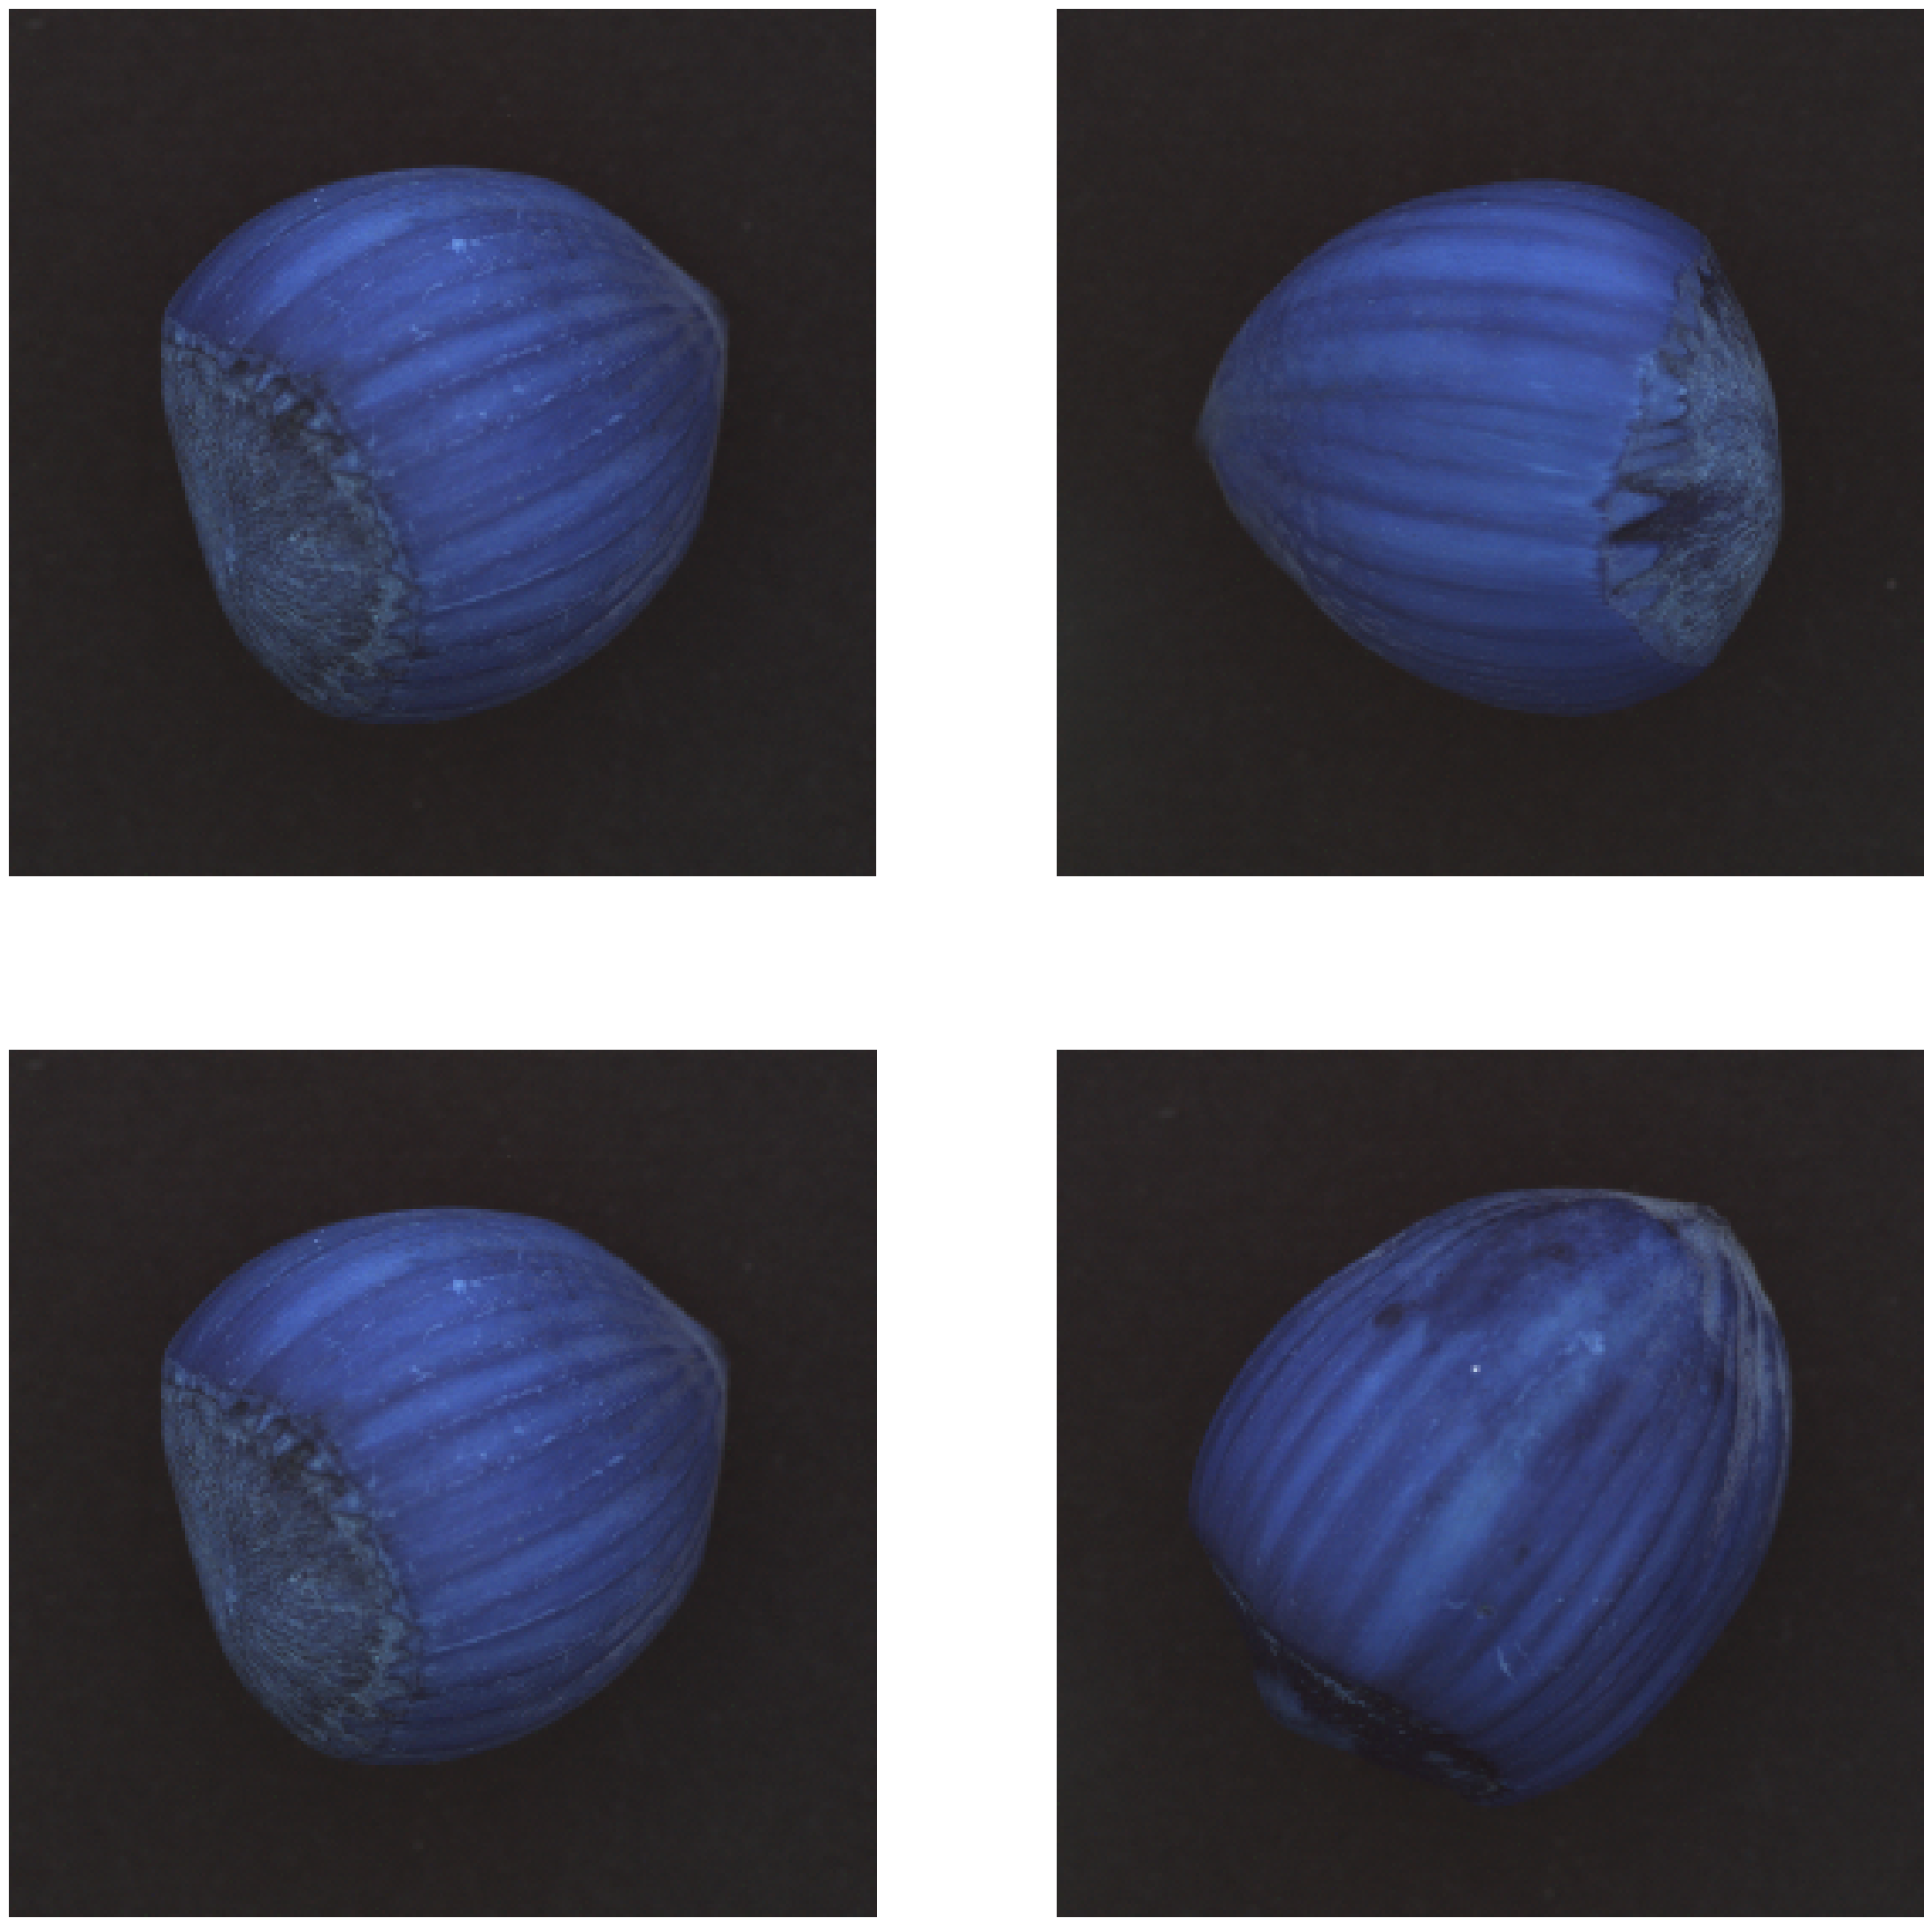

In [4]:

from data_loader import MVTecDRAEMTrainDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

def train_on_device(obj_names, args):


    for obj_name in obj_names:



        dataset = MVTecDRAEMTrainDataset(args.data_path + obj_name + "/train/good/", args.anomaly_source_path, resize_shape=[256, 256], ignore_black_region=False)

        dataloader = DataLoader(dataset, batch_size=args.bs,
                                shuffle=True, num_workers=1)
        

                # Get a batch of data
        batch_idx, batch_data = next(enumerate(dataloader))

        # Extract images from the batch
        images = batch_data['augmented_image']
        batch_idx, batch_data = next(enumerate(dataloader))

        # Extract images from the batch
        images = batch_data['augmented_image']
        print(images.shape)
        has_anomaly = batch_data['has_anomaly']

        imgs = []
        q=0
        for anom in has_anomaly:
             if not anom:
                  imgs.append(images[q])
             q+=1
     
        # Plot the images
        fig, axes = plt.subplots(2, 2, figsize=(28, 28))


        for i in range(2):
            for j in range(2):
                idx = i * 2 + j
                axes[i, j].imshow(np.transpose(imgs[idx], (1, 2, 0)))  # Assuming images are in (channels, height, width) format
                axes[i, j].axis('off')
        plt.savefig('anomaly_aug_example_2.png')
        plt.show()
        

import argparse
###########RUNNING ON SPLIT IMAGES
# Define your arguments and their default values
default_args = {
    'obj_id': 12,
    'bs': 32,
    'lr': 0.0001,
    'epochs': 8,
    'gpu_id': 0,
    'data_path': './datasets/mvtec/',
    'anomaly_source_path': './datasets/dtd/images/',
    'checkpoint_path': './checkpoints/',
    'log_path': './logs/',
    'visualize': False,
}

# Create an ArgumentParser to get the argument names
parser = argparse.ArgumentParser()
for arg_name, arg_value in default_args.items():
    arg_type = type(arg_value)
    parser.add_argument(f'--{arg_name}', action='store', type=arg_type, default=arg_value)

# Parse the arguments using the default values
args = parser.parse_args([])


obj_batch = [   ['cars'],
                ['capsule'],
                 ['bottle'],
                 ['carpet'],
                 ['leather'],
                 ['pill'],
                 ['transistor'],
                 ['tile'],
                 ['cable'],
                 ['zipper'],
                 ['toothbrush'],
                 ['metal_nut'],
                 ['hazelnut'],
                 ['screw'],
                 ['grid'],
                 ['wood']
                 ]

if int(args.obj_id) == -1:
        obj_list = ['cars',
                    'capsule',
                     'bottle',
                     'carpet',
                     'leather',
                     'pill',
                     'transistor',
                     'tile',
                     'cable',
                     'zipper',
                     'toothbrush',
                     'metal_nut',
                     'hazelnut',
                     'screw',
                     'grid',
                     'wood'
                     ]
        picked_classes = obj_list
else:
        picked_classes = obj_batch[int(args.obj_id)]

train_on_device(picked_classes, args)